# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [ ]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [ ]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.00318380439242
Mean of train-time output:  9.942290393204475
Mean of test-time output:  10.00318380439242
Fraction of train-time output set to zero:  0.70202
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.00318380439242
Mean of train-time output:  10.016958001514155
Mean of test-time output:  10.00318380439242
Fraction of train-time output set to zero:  0.399176
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.00318380439242
Mean of train-time output:  10.00611340230229
Mean of test-time output:  10.00318380439242
Fraction of train-time output set to zero:  0.249724
Fraction of test-time output set to zero:  0.0


## Question

1. Compare the Mean of input and Mean of train-time output. Explain the mathematical operation in your implementation that preserves the mean.

2. Observe the Fraction of test-time output set to zero. What does this value indicate about the layer's behavior during the test phase, and why is this design choice necessary?

## Answer:

1. Mean Comparison and Mathematical Operation:

Comparison: The mean of the train-time output is approximately equal to the mean of the input.
Explanation: This is achieved through Inverted Dropout. In this implementation, the active neurons during training are scaled by $1/p$ (where $p$ is the keep probability). Since a neuron is kept with probability $p$$p$ and dropped with probability $1-p$, the expected value becomes $E[out] = p \cdot (\frac{x}{p}) + (1-p) \cdot 0 = x$$E[out] = p \cdot (\frac{x}{p}) + (1-p) \cdot 0 = x$. This mathematical operation preserves the expected magnitude of the activations during training, matching the behavior at test time.

2. Test-time Behavior:

Observation: The fraction of output set to zero at test time is 0.0.
Indication: This indicates that dropout is disabled during the test phase, meaning all neurons are active and contributing to the output.
Necessity: This design choice is necessary to perform a deterministic forward pass that approximates the average prediction of the exponentially many thinned networks formed during training. By using the full network (and because we already scaled by $1/p$ during training), we can make efficient, deterministic predictions without needing to scale weights or sample masks at inference time.

## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [ ]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445610064986552e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [ ]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0.5
Initial loss:  2.309771209610118
W1 relative error: 2.694274363733021e-07
W2 relative error: 7.439246147919978e-08
W3 relative error: 1.910371122296728e-08
b1 relative error: 4.112891126518e-09
b2 relative error: 5.756217724722137e-10
b3 relative error: 1.3204470857080166e-10


Running check with dropout =  0.75
Initial loss:  2.306133548427975
W1 relative error: 8.72986097970181e-08
W2 relative error: 2.9777307885797295e-07
W3 relative error: 1.8832780806174298e-08
b1 relative error: 5.379486003985169e-08
b2 relative error: 3.6529949080385546e-09
b3 relative error: 9.987242764516995e-11


Running check with dropout =  1.0
Initial loss:  2.3053332250963194
W1 relative error: 1.2744095365229032e-06
W2 relative error: 4.678743300473988e-07
W3 relative error: 4.331673892536035e-08
b1 relative error: 4.0853539035931665e-08
b2 relative error: 1.951342257912746e-09
b3 relative error: 9.387142701440351e-11




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [ ]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300199
(Epoch 0 / 25) train acc: 0.158000; val_acc: 0.127000
(Epoch 1 / 25) train acc: 0.132000; val_acc: 0.121000
(Epoch 2 / 25) train acc: 0.204000; val_acc: 0.170000
(Epoch 3 / 25) train acc: 0.240000; val_acc: 0.192000
(Epoch 4 / 25) train acc: 0.312000; val_acc: 0.274000
(Epoch 5 / 25) train acc: 0.314000; val_acc: 0.269000
(Epoch 6 / 25) train acc: 0.364000; val_acc: 0.252000
(Epoch 7 / 25) train acc: 0.390000; val_acc: 0.281000
(Epoch 8 / 25) train acc: 0.386000; val_acc: 0.290000
(Epoch 9 / 25) train acc: 0.372000; val_acc: 0.267000
(Epoch 10 / 25) train acc: 0.424000; val_acc: 0.286000
(Epoch 11 / 25) train acc: 0.396000; val_acc: 0.275000
(Epoch 12 / 25) train acc: 0.458000; val_acc: 0.299000
(Epoch 13 / 25) train acc: 0.496000; val_acc: 0.305000
(Epoch 14 / 25) train acc: 0.492000; val_acc: 0.299000
(Epoch 15 / 25) train acc: 0.550000; val_acc: 0.296000
(Epoch 16 / 25) train acc: 0.584000; val_acc: 0.297000
(Epoch 17 / 25) train acc: 0.582000; val

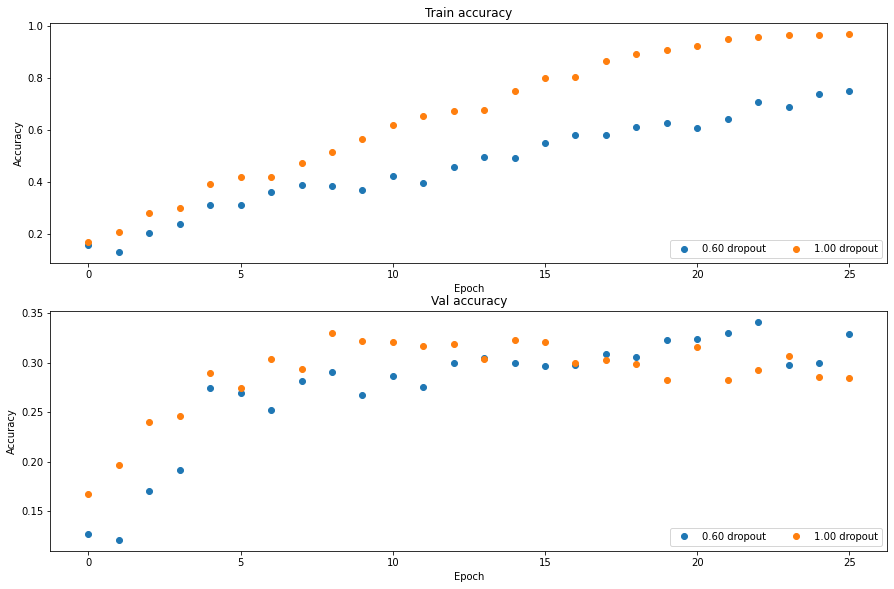

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

Yes, dropout is performing regularization.

Explanation:

Reduced Overfitting: Looking at the training output, the model without dropout (dropout=1.0) achieves a very high training accuracy (reaching 97% at epoch 25) but a relatively low validation accuracy (~28%). This large gap indicates severe overfitting—the model effectively memorized the training data.
Improved Generalization: The model with dropout (dropout=0.6) has a lower training accuracy (75%) but a higher validation accuracy (33%). The gap between training and validation accuracy is significantly smaller.
By randomly dropping neurons, dropout prevents the network from relying too heavily on any specific features (co-adaptation), forcing it to learn more robust features that generalize better to unseen data.

## Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1)
where if you get 55% or higher validation accuracy, you get full points.

In [ ]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #

# Define hyperparameters
# Using a 3-layer net (Input -> 500 -> 500 -> Output)
hidden_dims = [500, 500]

# Adam usually works best with learning rates around 1e-3
learning_rate = 1e-3
lr_decay = 0.95
reg = 0.001

# p=0.5 is a standard starting point for dropout (keep probability)
dropout = 0.5
weight_scale = 0.01

model = FullyConnectedNet(hidden_dims=hidden_dims,
                          weight_scale=weight_scale,
                          use_batchnorm=True,
                          dropout=dropout,
                          reg=reg)

solver = Solver(model, data,
                num_epochs=50,
                batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True,
                print_every=100)

solver.train()

print(f"Best Validation Accuracy: {solver.best_val_acc}")
# ================================================================ #


(Iteration 1 / 24500) loss: 2.401782
(Epoch 0 / 50) train acc: 0.160000; val_acc: 0.179000
(Iteration 101 / 24500) loss: 2.020781
(Iteration 201 / 24500) loss: 1.978201
(Iteration 301 / 24500) loss: 1.756052
(Iteration 401 / 24500) loss: 1.723178
(Epoch 1 / 50) train acc: 0.421000; val_acc: 0.456000
(Iteration 501 / 24500) loss: 1.773553
(Iteration 601 / 24500) loss: 1.939466
(Iteration 701 / 24500) loss: 1.624997
(Iteration 801 / 24500) loss: 1.724786
(Iteration 901 / 24500) loss: 1.694078
(Epoch 2 / 50) train acc: 0.464000; val_acc: 0.456000
(Iteration 1001 / 24500) loss: 1.718533
(Iteration 1101 / 24500) loss: 1.900527
(Iteration 1201 / 24500) loss: 1.826882
(Iteration 1301 / 24500) loss: 1.775309
(Iteration 1401 / 24500) loss: 2.047658
(Epoch 3 / 50) train acc: 0.492000; val_acc: 0.466000
(Iteration 1501 / 24500) loss: 1.722257
(Iteration 1601 / 24500) loss: 1.912171
(Iteration 1701 / 24500) loss: 1.756491
(Iteration 1801 / 24500) loss: 1.786081
(Iteration 1901 / 24500) loss: 1.919

(Iteration 15901 / 24500) loss: 1.456752
(Iteration 16001 / 24500) loss: 1.562792
(Iteration 16101 / 24500) loss: 1.378199
(Epoch 33 / 50) train acc: 0.641000; val_acc: 0.578000
(Iteration 16201 / 24500) loss: 1.505278
(Iteration 16301 / 24500) loss: 1.273361
(Iteration 16401 / 24500) loss: 1.386443
(Iteration 16501 / 24500) loss: 1.380043
(Iteration 16601 / 24500) loss: 1.445794
(Epoch 34 / 50) train acc: 0.658000; val_acc: 0.563000
(Iteration 16701 / 24500) loss: 1.365801
(Iteration 16801 / 24500) loss: 1.306687
(Iteration 16901 / 24500) loss: 1.382355
(Iteration 17001 / 24500) loss: 1.550287
(Iteration 17101 / 24500) loss: 1.229569
(Epoch 35 / 50) train acc: 0.670000; val_acc: 0.574000
(Iteration 17201 / 24500) loss: 1.444160
(Iteration 17301 / 24500) loss: 1.385044
(Iteration 17401 / 24500) loss: 1.254471
(Iteration 17501 / 24500) loss: 1.374772
(Iteration 17601 / 24500) loss: 1.395756
(Epoch 36 / 50) train acc: 0.690000; val_acc: 0.582000
(Iteration 17701 / 24500) loss: 1.415540
(